In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from pathlib import Path
import torch as th
from utils import create_directory
import numpy as np
import plot as plot
import PcmPy as pcm


# don't know if needed
import matplotlib.pyplot as plt

In [5]:
# read files 
data_dir = create_directory(directory_name='loss0_if')

model_num = 0
model_name = "model{:02d}".format(model_num)
phases = ['growing_up','NF1','FF1','NF2','FF2']
weights = ['gru.weight_ih_l0','gru.bias_ih_l0','gru.weight_hh_l0','gru.bias_hh_l0','fc.weight','fc.bias']
labels = ['GU','NF1','FF1','NF2','FF2']
titles = ['ih_b','ih_w','hh_b','hh_w','fc_b','fc_w']

weights_dict = {weight:[] for weight in weights}


for phase in phases:
    file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
    w = th.load(file)
    for weight in weights:
        weights_dict[weight].append(np.ravel(w[weight].numpy()))


cond_vec = np.arange(0,len(phases))
part_vec = np.zeros_like(cond_vec)

n_cond = len(phases)

from PcmPy.matrix import indicator
from scipy.linalg import pinv

G = np.zeros((len(weights),n_cond,n_cond)) # Allocate memory
rdm = np.zeros_like(G) 
for i,weight in enumerate(weights):

    Y = np.array(weights_dict[weight])
    N , n_channel = Y.shape
    X = pcm.matrix.indicator(part_vec)
    Y -= X @ pinv(X) @ Y # Remove mean
    Z = cond_vec
    Z = indicator(Z)
    A = pinv(Z) @ Y

    G[i,:,:] = A @ A.T
    rdm[i,:,:] = pcm.G_to_dist(G[i,:,:])

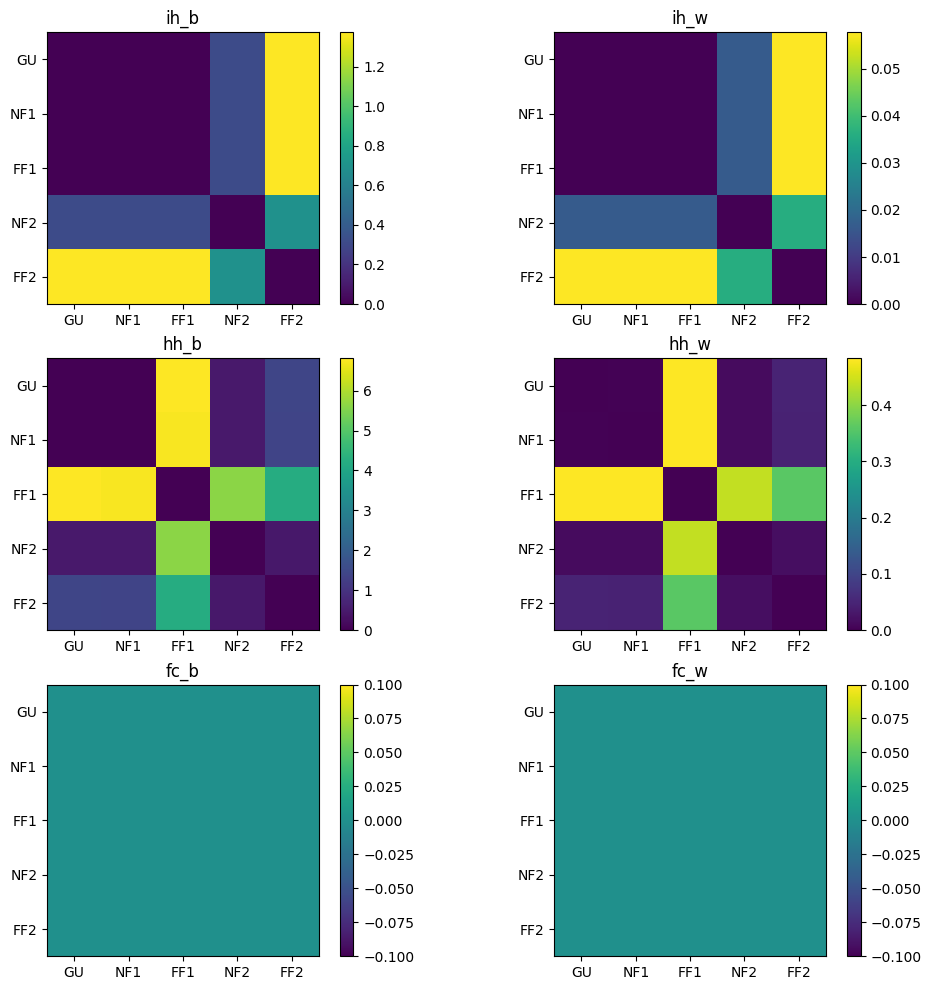

In [6]:
plot.plot_Gs(rdm,labels=labels,titles=titles,vmin=0)

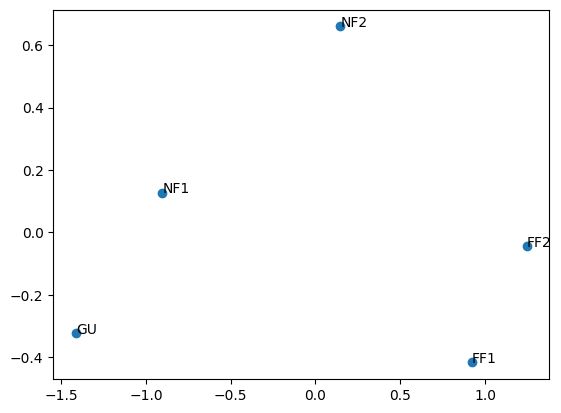

In [4]:
# calculate mds
W,Glam = pcm.classical_mds(G[2])
plt.scatter(W[:,0],W[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (W[i, 0], W[i, 1]))